In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import clear_output, display

## Modeling

In [2]:
features = [
    'asst_tot', 'asst_tot_quantile_values',
    'financial_leverage', 'financial_leverage_quantile_values',
    'profitability_ratio', 'profitability_ratio_quantile_values',
    'net_income_growth', 'net_income_growth_quantile_values',
    'quick_ratio_v2', 'quick_ratio_v2_quantile_values',
    'sales_growth', 'sales_growth_quantile_values',
    'cash_assets_ratio', 'cash_assets_ratio_quantile_values',
    'dscr', 'dscr_quantile', 'ebitda','is_first_occurrence'
]

In [3]:
df = pd.read_csv('../data/processed_data.csv')
df.shape

(1023552, 72)

In [140]:
df[['financial_leverage','financial_leverage_quantile','financial_leverage_quantile_values']].head()

,financial_leverage,financial_leverage_quantile,financial_leverage_quantile_values
0,0.923659,9.0,0.018178
1,0.985222,10.0,0.016486
2,0.987754,10.0,0.016486
3,0.768580,6.0,0.008812
4,0.810523,7.0,0.011098


In [137]:
df[['roa','profitability_ratio']]

,roa,profitability_ratio
0,6.20,0.020763
1,-2.76,-0.051692
2,-2.17,-0.039385
3,-4.08,-0.044052
4,-3.81,-0.041752
...,...,...
1023547,-0.08,0.002484
1023548,1.92,0.004856
1023549,-6.78,-0.079854
1023550,0.43,0.001288


In [5]:
modeling_df = df.drop(['def_date'],axis=1)
modeling_df.isna().sum().sort_values().tail(10)

margin_fin                40758
roe                       72937
debt_bank_lt              90971
debt_fin_lt               92068
AP_lt                     92244
AP_st                    120635
debt_bank_st             121331
debt_fin_st              122772
days_rec                 740211
eqty_corp_family_tot    1023552
dtype: int64

In [6]:
# modeling_df['HQ_city'] = modeling_df['HQ_city'].fillna(-1.0)

In [7]:
modeling_df[~modeling_df.index.isin(modeling_df.dropna().index)]['default'].value_counts()

default
0    1010614
1      12938
Name: count, dtype: int64

In [8]:
 modeling_df['sales_growth'] = modeling_df['sales_growth'].replace([np.inf,-np.inf],0)

In [11]:
modeling_df[features].isna().sum(axis=0)

asst_tot                               0
asst_tot_quantile_values               0
financial_leverage                     0
financial_leverage_quantile_values     1
profitability_ratio                    0
profitability_ratio_quantile_values    1
net_income_growth                      0
net_income_growth_quantile_values      1
quick_ratio_v2                         0
quick_ratio_v2_quantile_values         0
sales_growth                           0
sales_growth_quantile_values           0
cash_assets_ratio                      0
cash_assets_ratio_quantile_values      0
dscr                                   0
dscr_quantile                          0
ebitda                                 0
is_first_occurrence                    0
dtype: int64

In [12]:
### we'll try dropping NA's for now
modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()

In [13]:
modeling_df.sort_values('stmt_date', inplace=True)

In [14]:
train_df = modeling_df.iloc[:int(len(modeling_df)*0.8)]

In [15]:
test_df = modeling_df[~modeling_df.index.isin(train_df.index)]

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [17]:
# test_df[feature_list].isna().sum()

In [141]:
quantile_features = [
  'asst_tot_quantile_values',
 'financial_leverage_quantile_values',
 'profitability_ratio_quantile_values',
 # 'net_income_growth_quantile_values',
 'quick_ratio_v2_quantile_values',
 # 'sales_growth_quantile_values',
 'cash_assets_ratio_quantile_values',
 'dscr_quantile',
    # 'ebitda',
    # 'is_first_occurrence'
]


In [142]:
# train_df[quantile_features]

In [143]:
# feature_list = [
#                 'HQ_city',
#                  'legal_struct',
#                  'ateco_sector',
#                   'asst_tot',
#                  'financial_leverage',
#                  'profitability_ratio',
#                  'profit',
#                  'net_income_growth',
#                  'quick_ratio_v2',
#                  'sales_growth',
#                  'cash_assets_ratio',
#                  'dscr'
#                  ]

In [144]:
formula = 'default ~ '+' + '.join(quantile_features)
formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile'

In [145]:
model = smf.logit(formula, data = train_df) 
logit_model_sm = model.fit()
print(logit_model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.063499
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               818840
Model:                          Logit   Df Residuals:                   818833
Method:                           MLE   Df Model:                            6
Date:                Sat, 09 Nov 2024   Pseudo R-squ.:                  0.1156
Time:                        16:31:11   Log-Likelihood:                -51995.
converged:                       True   LL-Null:                       -58791.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.5603      0.094

In [146]:
print(logit_model_sm.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
asst_tot_quantile_values                1.0421      0.083     12.594      0.000       0.880       1.204
financial_leverage_quantile_values      0.0451      0.002     21.491      0.000       0.041       0.049
profitability_ratio_quantile_values     0.1218      0.002     60.474      0.000       0.118       0.126
quick_ratio_v2_quantile_values         -0.1622      0.025     -6.401      0.000      -0.212      -0.113
cash_assets_ratio_quantile_values       0.0634      0.041      1.558      0.119      -0.016       0.143
dscr_quantile                          -0.0006   1.22e-05    -52.429      0.000      -0.001      -0.001


In [147]:
predictions = test_df[['default']].copy()
predictions['predicted_probability'] = logit_model_sm.predict(test_df)
# predictions.dropna(inplace=True)
predictions.head()

,default,predicted_probability
7620,0,0.002650
563844,0,0.008293
644987,0,0.004794
95331,1,0.024650
563853,0,0.012398


In [148]:
predictions['predicted_probability'].describe()

count    204711.000000
mean          0.013490
std           0.023851
min           0.001259
25%           0.004224
50%           0.008324
75%           0.016739
max           0.652917
Name: predicted_probability, dtype: float64

In [110]:
predictions['predicted_probability'].min()

np.float64(0.0007376711771845617)

In [111]:
predictions['default'].mean()

np.float64(0.008949201557317389)

In [112]:
from sklearn.calibration import CalibratedClassifierCV

In [113]:
cal_model = CalibratedClassifierCV

0.8330730831444709 0.9995401655379281


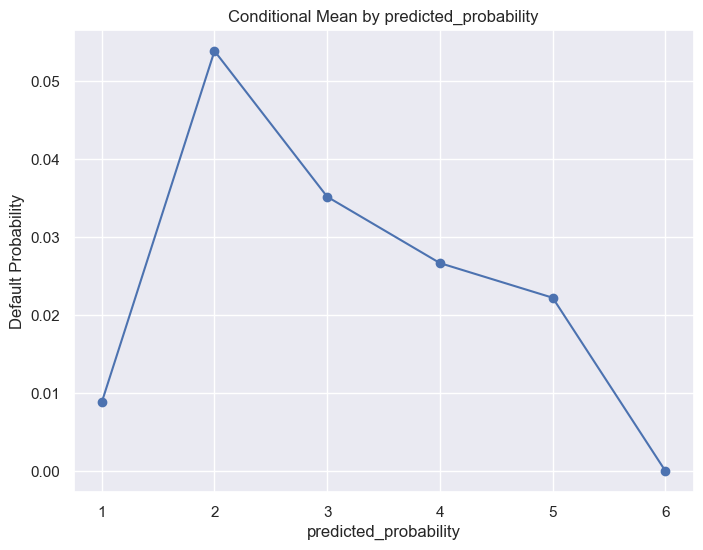

In [114]:
field = 'predicted_probability'
# custom_bins = [0,.10,.11,.12,.13,.14,.19]
cut, bins = pd.cut(predictions['predicted_probability'], bins=6, labels=False, retbins=True, duplicates = 'drop')
cut+=1# Adding 1 to make quantiles start from 1
default_prob_values = predictions.groupby(cut)[['default']].mean()
# print(bins)
print(bins[-2],bins[-1])
plt.figure(figsize=(8, 6))
plt.plot(default_prob_values.index, default_prob_values.default, marker='o', linestyle='-', color='b')
plt.title(f'Conditional Mean by {field}')
plt.xlabel(field)
plt.ylabel('Default Probability')
plt.grid(True)
plt.show()

In [115]:
predictions['predicted_probability'].min()

np.float64(0.0007376711771845617)

In [116]:
from sklearn import metrics

In [117]:
metrics.roc_auc_score(y_score=predictions['predicted_probability'], y_true=predictions['default'])

np.float64(0.8005826568683537)

In [118]:
import seaborn as sns
sns.set()

<Axes: xlabel='predicted_probability', ylabel='Count'>

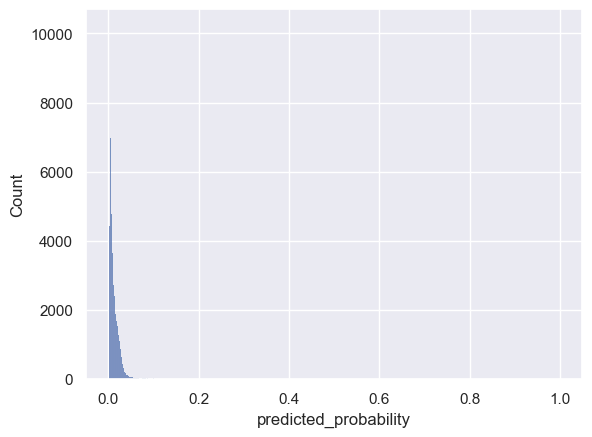

In [119]:
sns.histplot(predictions['predicted_probability'])

ROC AUC 0.8005826568683537


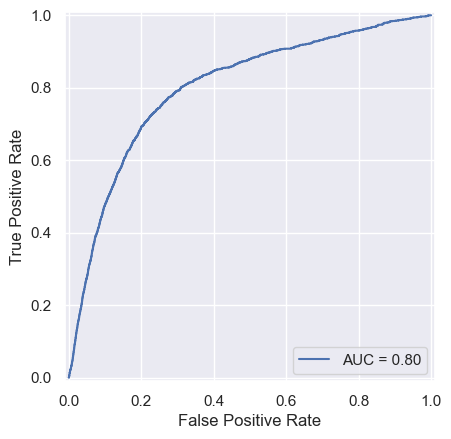

In [120]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['default'], predictions['predicted_probability'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

## Walk forward

In [121]:
def predictor(new_df, model):
    predictions = model.predict(new_df)
    return(predictions)

In [122]:
def preprocessor(df, preproc_params = {}, new = True):

    quantiles = preproc_params['quantiles']
    
    to_quantile_features = ['asst_tot',
                 'financial_leverage',
                 'profitability_ratio',
                 'profit',
                 # 'net_income_growth',
                 'quick_ratio_v2',
                 # 'sales_growth',
                 'cash_assets_ratio',
                 'dscr']

    feature_names = []
    
    for feature in to_quantile_features:
        if new:
            cut, bins = pd.qcut(df[feature], q=quantiles, retbins=True,labels=False, duplicates='drop')
            
            prob_values = df.groupby(cut)[['default']].mean()

            feature_name = f'{feature}_quantile_value'
            feature_names.append(feature_name)
            
            df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']
            preproc_params['quantile_bins'][feature] = bins
            
        else:
            if feature not in preproc_params['quantile_bins']:
                raise Exception("Error bins haven't been fitted")
            bins = preproc_params['quantile_bins'][feature]
            
            cut = pd.cut(df[feature], bins=bins, labels=False, include_lowest=True)
            prob_values = df.groupby(cut)[['default']].mean()

            feature_name = f'{feature}_quantile_value'
            feature_names.append(feature_name)
            
            df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']

    preproc_params['features'] = feature_names
    
    return(df, preproc_params)

In [123]:
def estimator(df, fitting_algo, est_params = {}):
    
    my_formula = est_params['formula']
    model = fitting_algo(my_formula, data = df) 
    fitted_model = model.fit(disp=False)
    
    return(fitted_model)

In [124]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [125]:
def walk_forward_harness(df, preprocessor, estimator, predictor, 
                         start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    preproc_params = {
        'quantiles':20,
        'quantile_bins':{},
        'features': quantile_features
    }
    
    
    df[date_col] = pd.to_datetime(df[date_col])
    walk_range = df[date_col].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        
        # train_data_proc , preproc_params = preprocessor(train_data, preproc_params, new=True)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        train_data_proc = train_data
        test_data_proc = test_data
        
        algo_params = {'formula': 'default ~ '+' + '.join(preproc_params['features'])}
        
        algo = smf.logit
    
        trained_model = estimator(train_data_proc, algo, algo_params)
        prediction = predictor(test_data_proc, trained_model)
        
        
        labels += list(test_data['default'].values)
        predictions += list(prediction.values)
        
        group_list += test_idx * len(prediction.values)
        
        try:
            preds = pd.DataFrame([labels,predictions,group_list]).T
            preds.columns = ['label','prediction','group']
            preds = preds.dropna()
            score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
            
        except Exception as e:
            print(F'Error scoring {e}')
            score = np.nan

        
        stats_list.append(score)
        model_list.append(trained_model)
        

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [126]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           preprocessor = preprocessor, 
                                                           estimator = estimator, 
                                                           predictor = predictor, 
                                                           date_col = 'stmt_date',
                                                           start = 1, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

In [127]:
predictions.isna().sum()

label          0
prediction    17
group          0
dtype: int64

In [130]:
predictions = predictions.dropna()

ROC AUC 0.7749998931754506


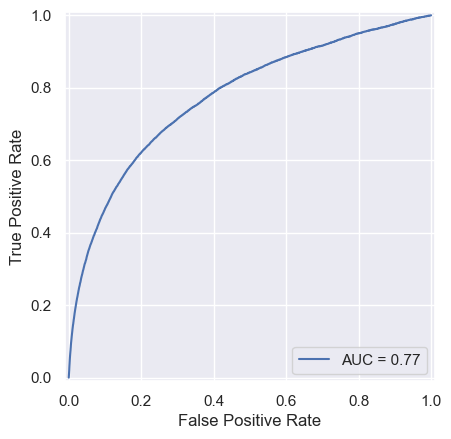

In [131]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

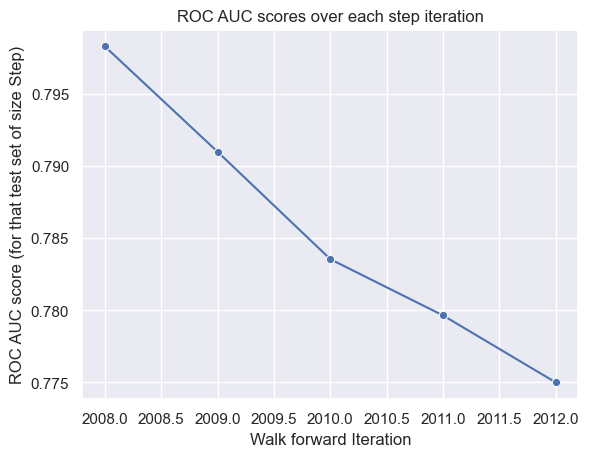

In [132]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [133]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

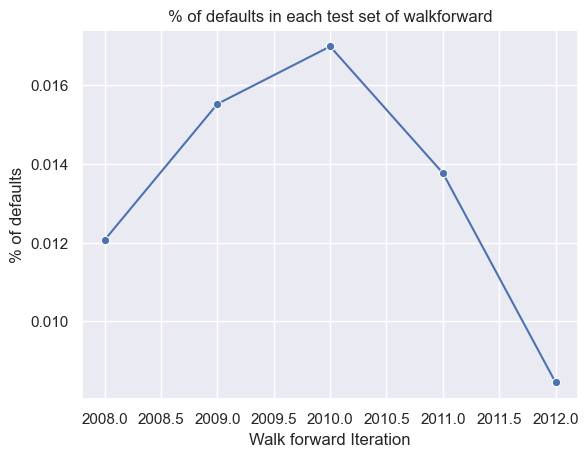

In [95]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')